In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime
import re

# Twitter data

## text preprocess

In [2]:
twitter1 = pd.read_csv("trayvontweets/Trayvon Tweets 2012.csv",encoding = "latin1",index_col = 0)

/Users/ycr/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ycr/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
twitter2 = pd.read_csv("trayvontweets/Trayvon Tweets 2013.csv",encoding = "latin1", index_col = 0)

In [4]:
def date(dates):
    delta=datetime.timedelta(days=dates)
    today=datetime.datetime.strptime('1899-12-30 00:00:00','%Y-%m-%d %H:%M:%S')+delta
    return datetime.datetime.strftime(today,'%Y-%m-%d %H:%M:%S')

In [5]:
twitter = pd.concat([twitter1,twitter2],ignore_index=True)

In [6]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097150 entries, 0 to 2097149
Data columns (total 20 columns):
id                      int64
message_id              int64
user_handle             object
orig_user_id            int64
orig_user_handle        object
topsy_type              object
orig_date_posted_gmt    float64
date_posted_gmt         float64
message                 object
orig_user_location      object
coordinates             object
tweet_location          object
longitude               float64
latitude                float64
created_at_gmt          float64
seconds_after_event     float64
FIPS                    object
County                  object
City                    object
State                   object
dtypes: float64(6), int64(3), object(11)
memory usage: 320.0+ MB


-----

In [7]:
twitter = twitter.sample(n = 1000)
twitter = twitter.reset_index()

In [8]:
twitter.loc[:,'message'] = twitter.loc[:,'message'].fillna('nan')

In [9]:
twitter = twitter.drop('index',axis = 1)

In [10]:
twitter.loc[:,'topsy_type'].unique()

array(['retweet:reply', 'tweet', 'retweet:native'], dtype=object)

In [11]:
# uncomment to output twitter message as txt
#twitter_message = pd.DataFrame(twitter_message)
#twitter_message = twitter_message.reset_index()
#twitter_message.to_csv("twitter_message",sep = "\t",index=False, header=False)

In [12]:
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [13]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96", this mothod will remove all emojis"""   
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

In [14]:
def replaceURL(text):
    """ remove url address"""
    text = re.sub('((www\.[^\s]+)|(http?://[^\s]+))','',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [15]:
def replaceAtUser(text):
    """ remove"@user" """
    text = re.sub('@[^\s]+','',text) 
    return text

In [16]:
def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)  #only remove# or remove all?
    return text

In [17]:
def removeRT(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'\bRT\b', r'', text)
    return text

In [18]:
def removePunctuations(text):
    """remove Punctuations"""
    text = re.sub("[\.\,\!\?\:\;\-\=\&\(\)\"]", " ", text)
    return text

In [19]:
contraction_map = {}
with open('contractions.txt') as file:
    for line in file:
        (key,val)= line.rstrip().split(":")
        contraction_map[key] = val
        
def replaceContractions(word):
    """Remove contractions """
    if word in contraction_map.keys():
        return contraction_map[word].split()
    else:
        return word

In [20]:
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())

slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

In [21]:
#spell correction
#correct I to a, but keep i
#need more work on it
def words(text): 
    return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('corporaForSpellCorrection.txt').read()))

def P(word, N=sum(WORDS.values())): 
    """P robability of `word`. """
    return WORDS[word] / N

def spellCorrection(word): 
    """ Most probable spelling correction for word. """
    return max(candidates(word), key=P)

def candidates(word): 
    """ Generate possible spelling corrections for word. """
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    """ The subset of `words` that appear in the dictionary of WORDS. """
    return set(w for w in words if w in WORDS)

def edits1(word):
    """ All edits that are one edit away from `word`. """
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    """ All edits that are two edits away from `word`. """
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [22]:
#use bag model or sequence model?
def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue

        words.append(word)
        i += 1
    return words

In [23]:
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import MWETokenizer
tokenizer = TweetTokenizer()
multi_tokenizer = MWETokenizer()
multi_tokenizer.add_mwe(('b', 'l', 'm'))
multi_tokenizer.add_mwe(('r', 'i', 'p')) #add by hand?
twitter_tokens = []
twitter_token_cleaned = []
for i in range(twitter.shape[0]):
    twitter.loc[i,'message_cleaned'] = removeUnicode(twitter.loc[i,'message'])
    twitter.loc[i,'message_cleaned'] = replaceURL(twitter.loc[i,'message_cleaned'])
    twitter.loc[i,'message_cleaned'] = replaceAtUser(twitter.loc[i,'message_cleaned'])    
    twitter.loc[i,'message_cleaned'] = removeHashtagInFrontOfWord(twitter.loc[i,'message_cleaned'])
    twitter.loc[i,'message_cleaned'] = removeRT(twitter.loc[i,'message_cleaned'])
    twitter.loc[i,'message_cleaned'] = replaceSlang(twitter.loc[i,'message_cleaned'])
    twitter.loc[i,'message_cleaned'] = removePunctuations(twitter.loc[i,'message_cleaned'])
    twitter.loc[i,'message_cleaned'] = twitter.loc[i,'message_cleaned'].lower()
    twitter_tokens.append(multi_tokenizer.tokenize(tokenizer.tokenize(twitter.loc[i,'message_cleaned'])))
    
    #replace contraction and spell correction begins
    for j in range(0,len(twitter_tokens[i])):
        twitter_tokens[i][j] = spellCorrection(twitter_tokens[i][j])   #spell correction will take a long time
        twitter_tokens[i][j] = replaceContractions(twitter_tokens[i][j])
    for j in range(0,len(twitter_tokens[i])):
        twitter_token_cleaned.append([])
        if isinstance(twitter_tokens[i][j],list):
            for item in twitter_tokens[i][j]:
                twitter_token_cleaned[i].append(item)
        else:
            twitter_token_cleaned[i].append(twitter_tokens[i][j])
    #replace contraction and spell correction ends
    
    twitter_token_cleaned[i] = replaceNegations(twitter_token_cleaned[i])

In [132]:
twitter_message_cleaned = []
for message in twitter_token_cleaned:
    twitter_message_cleaned.append(' '.join(message))
twitter_message_cleaned = pd.Series(twitter_message_cleaned)

output:    
**twitter_token_cleaned**:  list of list of words       
twitter_token_cleaned[0] is all the words of row0 in twitter.          
**twitter_message_cleaned**: series of cleaned twitter message     
delete all punctuation, @user, url, hashtags; lower case, deal with negation, spell correction

In [135]:
twitter_token_cleaned[:30]

[['yes',
  'they',
  'can',
  'handle',
  'the',
  'truth',
  'they',
  'just',
  'want',
  'to',
  'kill',
  'zimmerman',
  'a',
  'hispanic'],
 ['for',
  'the',
  'right',
  'amount',
  'of',
  'money',
  'people',
  'will',
  'do',
  'anything',
  'your',
  'george',
  "zimmerman's",
  'attorney',
  'defending',
  'a',
  'guy',
  'who',
  'stalked',
  'shot',
  'a',
  '17',
  'y',
  'o',
  'kid',
  's'],
 ['glued', 'to', 'this', 'george', 'zimmerman', 'bond', 'hearing'],
 ['dog',
  'window',
  'the',
  'death',
  'of',
  'trayvon',
  'martin',
  'confronting',
  'the',
  'problem',
  'of',
  'enduring',
  'racism'],
 ['sabine',
  'fulton',
  'talks',
  'about',
  'the',
  'trayvon',
  'martin',
  'foundation',
  'at',
  'press',
  'conference',
  'photo',
  'by',
  'monica',
  '_'],
 ['your',
  'ignorant',
  'can',
  'wait',
  '2',
  'get',
  '2',
  'heaven',
  'in',
  'on',
  'suck',
  'trayvon',
  'martin',
  'dick',
  '2',
  'let',
  'him',
  'know',
  'i',
  'love',
  'him',
  '

In [133]:
twitter_message_cleaned.head()

0    yes they can handle the truth they just want t...
1    for the right amount of money people will do a...
2          glued to this george zimmerman bond hearing
3    dog window the death of trayvon martin confron...
4    sabine fulton talks about the trayvon martin f...
dtype: object

- nan in message:      
is it all "reply"?
- negation    
we use: find "not" and replace with antonym    
maybe sequential model?     
or do not deal with negations?
- emojis      
how to read emojis and keep the unicodes?     
https://unicode.org/emoji/charts/full-emoji-list.html#1f600     
https://anaconda.org/conda-forge/emoji     
- get all hashtags? create a new column?
- special words will be tokenized, like R.I.P, using mwetokenizer, add by hands
- count upper case or ignore them(convert to lower case)?

## read LIWC dictionary

In [24]:
file = open("LIWC Dictionary/LIWC_dic.txt","r")

LIWC = file.readlines()
LIWC_dict = {}
for line in LIWC:
    line = line.split(',')
    category = line[0]
    words = line[1].split(' ')
    words[-1] = words[-1][:-1]
    LIWC_dict[category] = words

## Rule-based Model

In [25]:
LIWC_dict

{'Function': ['a',
  'however',
  'so',
  "would've",
  'about',
  'howre',
  'somebod*',
  "wouldn't",
  'above',
  'hows',
  'somehow',
  'wouldnt',
  'absolutely',
  'i',
  'someone*',
  'wouldve',
  'abt',
  "i'd",
  'something*',
  "y'all",
  'across',
  "i'd've",
  'somewhat',
  "y'all's",
  'actually',
  "i'll",
  'somewhere',
  'ya',
  'after',
  "i'm",
  'soon',
  "ya'll*",
  'again',
  "i've",
  'sooo*',
  'yall',
  'against',
  'id',
  'specifically',
  'yalls',
  'ahead',
  'idc',
  'still',
  'ye',
  "ain't",
  'idgaf',
  'stuff',
  'yet',
  'aint',
  'idk',
  'subsequently',
  'yinz*',
  'almost',
  'idontknow',
  'such',
  'yoyou',
  'along',
  'idve',
  'suddenly',
  "you'd",
  'already',
  'if',
  'supposedly',
  "you'll",
  'also',
  'ikr',
  'than',
  "you're",
  'altho',
  'ily*',
  'that',
  "you've",
  'although',
  'im',
  "that'd",
  'youd',
  'am',
  'ima',
  "that'll",
  'youll',
  'amid',
  'imean',
  "that's",
  'your',
  'amidst',
  'imma',
  'thatd',
  'yo

select these emotions:
- Posemo
- Anger
- Sad

In [26]:
posemo_pattern = str()
for i in range(0,len(LIWC_dict['Posemo'])-1):
    posemo_pattern = posemo_pattern+LIWC_dict['Posemo'][i]+'|'
posemo_pattern = posemo_pattern+LIWC_dict['Posemo'][i+1]
posemo_pattern = re.compile(posemo_pattern)

anger_pattern = str()
for i in range(0,len(LIWC_dict['Anger'])-1):
    anger_pattern = anger_pattern+LIWC_dict['Anger'][i]+'|'
anger_pattern = anger_pattern+LIWC_dict['Anger'][i+1]
anger_pattern = re.compile(anger_pattern)

sad_pattern = str()
for i in range(0,len(LIWC_dict['Sad'])-1):
    sad_pattern = sad_pattern+LIWC_dict['Sad'][i]+'|'
sad_pattern = sad_pattern+LIWC_dict['Sad'][i+1]
sad_pattern = re.compile(sad_pattern)

In [27]:
### include regex
#### not correct, 词典pattern有问题
twitter_tag = []
for j in range(0,len(twitter_token_cleaned)):
    sentence = twitter_token_cleaned[j]
    count = {}
    count['posemo'] = len(list(filter(posemo_pattern.findall,sentence)))
    count['anger'] = len(list(filter(anger_pattern.findall,sentence)))
    count['sad'] = len(list(filter(sad_pattern.findall,sentence)))
    
    print(count)
    if max(count.values()) == 0:
        twitter_tag.append('nan')
    else:
        tag = max(count,key = count.get)     
        twitter_tag.append(tag)

{'posemo': 9, 'anger': 1, 'sad': 0}
{'posemo': 11, 'anger': 1, 'sad': 0}
{'posemo': 4, 'anger': 0, 'sad': 0}
{'posemo': 8, 'anger': 1, 'sad': 0}
{'posemo': 7, 'anger': 1, 'sad': 0}
{'posemo': 12, 'anger': 1, 'sad': 0}
{'posemo': 9, 'anger': 1, 'sad': 1}
{'posemo': 8, 'anger': 3, 'sad': 0}
{'posemo': 2, 'anger': 0, 'sad': 0}
{'posemo': 9, 'anger': 0, 'sad': 1}
{'posemo': 10, 'anger': 2, 'sad': 1}
{'posemo': 8, 'anger': 1, 'sad': 0}
{'posemo': 15, 'anger': 0, 'sad': 1}
{'posemo': 6, 'anger': 0, 'sad': 0}
{'posemo': 4, 'anger': 3, 'sad': 0}
{'posemo': 11, 'anger': 0, 'sad': 0}
{'posemo': 11, 'anger': 2, 'sad': 1}
{'posemo': 1, 'anger': 0, 'sad': 0}
{'posemo': 9, 'anger': 2, 'sad': 1}
{'posemo': 6, 'anger': 0, 'sad': 0}
{'posemo': 7, 'anger': 2, 'sad': 1}
{'posemo': 7, 'anger': 0, 'sad': 1}
{'posemo': 5, 'anger': 1, 'sad': 0}
{'posemo': 3, 'anger': 1, 'sad': 0}
{'posemo': 8, 'anger': 3, 'sad': 0}
{'posemo': 6, 'anger': 1, 'sad': 0}
{'posemo': 3, 'anger': 1, 'sad': 1}
{'posemo': 7, 'anger':

{'posemo': 7, 'anger': 2, 'sad': 1}
{'posemo': 9, 'anger': 2, 'sad': 0}
{'posemo': 7, 'anger': 1, 'sad': 0}
{'posemo': 10, 'anger': 1, 'sad': 0}
{'posemo': 11, 'anger': 1, 'sad': 0}
{'posemo': 3, 'anger': 0, 'sad': 0}
{'posemo': 5, 'anger': 2, 'sad': 0}
{'posemo': 7, 'anger': 0, 'sad': 2}
{'posemo': 4, 'anger': 5, 'sad': 0}
{'posemo': 10, 'anger': 3, 'sad': 2}
{'posemo': 2, 'anger': 0, 'sad': 0}
{'posemo': 4, 'anger': 1, 'sad': 0}
{'posemo': 11, 'anger': 5, 'sad': 0}
{'posemo': 5, 'anger': 0, 'sad': 0}
{'posemo': 2, 'anger': 0, 'sad': 0}
{'posemo': 10, 'anger': 1, 'sad': 1}
{'posemo': 9, 'anger': 2, 'sad': 0}
{'posemo': 7, 'anger': 2, 'sad': 1}
{'posemo': 7, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 6, 'anger': 2, 'sad': 0}
{'posemo': 6, 'anger': 0, 'sad': 1}
{'posemo': 5, 'anger': 1, 'sad': 0}
{'posemo': 4, 'anger': 0, 'sad': 1}
{'posemo': 6, 'anger': 2, 'sad': 1}
{'posemo': 6, 'anger': 1, 'sad': 0}
{'posemo': 8, 'anger': 1, 'sad': 0}
{'posemo': 15, 'anger':

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 'sad': 0}
{'posemo': 0, 'anger': 0, 's

In [28]:
twitter_token_cleaned[0]

['yes',
 'they',
 'can',
 'handle',
 'the',
 'truth',
 'they',
 'just',
 'want',
 'to',
 'kill',
 'zimmerman',
 'a',
 'hispanic']

In [29]:
####just count
"""
twitter_tag = []
for j in range(0,len(twitter_token_cleaned)):
    sentence = twitter_token_cleaned[j]
    count = {}
    count['posemo'] = 0
    count['anger'] = 0
    count['sad'] = 0

    for i in range(0,len(sentence)):
        word = sentence[i]
        if word in LIWC_dict['Posemo']:
            count['posemo'] = count['posemo']+1
        elif word in LIWC_dict['Anger']:
            count['anger'] = count['anger']+1
        elif word in LIWC_dict['Sad']:
            count['sad'] = count['sad']+1
        else:
            pass
    if max(count.values()) == 0:
        twitter_tag.append('nan')
    else:
        tag = max(count,key = count.get)     
        twitter_tag.append(tag)
"""

"\ntwitter_tag = []\nfor j in range(0,len(twitter_token_cleaned)):\n    sentence = twitter_token_cleaned[j]\n    count = {}\n    count['posemo'] = 0\n    count['anger'] = 0\n    count['sad'] = 0\n\n    for i in range(0,len(sentence)):\n        word = sentence[i]\n        if word in LIWC_dict['Posemo']:\n            count['posemo'] = count['posemo']+1\n        elif word in LIWC_dict['Anger']:\n            count['anger'] = count['anger']+1\n        elif word in LIWC_dict['Sad']:\n            count['sad'] = count['sad']+1\n        else:\n            pass\n    if max(count.values()) == 0:\n        twitter_tag.append('nan')\n    else:\n        tag = max(count,key = count.get)     \n        twitter_tag.append(tag)\n"

## LDA


In [86]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [94]:
twitter_message_cleaned = twitter_message_cleaned[twitter_message_cleaned!=""]

In [124]:
n_topics = [3,5,7,9]
learning_decay = [0.5,0.7,0.9]
params = {'latentdirichletallocation__n_components': n_topics,'latentdirichletallocation__learning_decay':learning_decay}
model = GridSearchCV(make_pipeline(TfidfVectorizer(min_df=2,max_df=0.9),
                                  LatentDirichletAllocation(learning_method = 'online')), 
                     param_grid=params)
model.fit(twitter_message_cleaned)

/Users/ycr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=2,
                                                        ngram_range=(1, 1),
                          

In [125]:
model.best_params_

{'latentdirichletallocation__learning_decay': 0.9,
 'latentdirichletallocation__n_components': 3}

In [126]:
print("Best Log Likelihood Score: ",model.best_score_)

Best Log Likelihood Score:  -7662.629248820514


In [127]:
grid_score = pd.DataFrame(model.cv_results_['mean_test_score'].reshape(3,4))
grid_score.columns = n_topics
grid_score.index = learning_decay

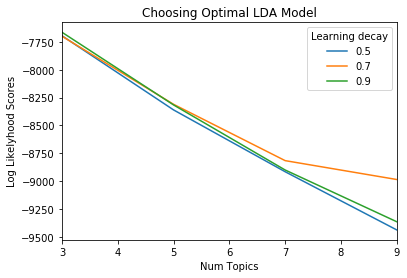

In [131]:
grid_score.T.plot()
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')

In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

In [66]:
#calculate perplexity
for i in range(5,101,10):
    n_topics = i

    print("Fitting LDA models with tf features, #topics = ", n_topics)

    lda = LatentDirichletAllocation(n_components=n_topics, 
                                    random_state=0)
    lda_message = lda.fit_transform(tf_message)

    lda_perplexity = lda.perplexity(tf_message)

    print('sklearn preplexity: train=%.3f%',lda_perplexity)

Fitting LDA models with tf features, #topics =  5
sklearn preplexity: train=%.3f% 2970.1930476258744
Fitting LDA models with tf features, #topics =  15
sklearn preplexity: train=%.3f% 12719.770953109899
Fitting LDA models with tf features, #topics =  25
sklearn preplexity: train=%.3f% 31810.945605354947
Fitting LDA models with tf features, #topics =  35
sklearn preplexity: train=%.3f% 62923.0271638827
Fitting LDA models with tf features, #topics =  45
sklearn preplexity: train=%.3f% 104750.87995788775
Fitting LDA models with tf features, #topics =  55
sklearn preplexity: train=%.3f% 185400.37506981086
Fitting LDA models with tf features, #topics =  65
sklearn preplexity: train=%.3f% 241420.75642718608
Fitting LDA models with tf features, #topics =  75
sklearn preplexity: train=%.3f% 383497.3839413805
Fitting LDA models with tf features, #topics =  85
sklearn preplexity: train=%.3f% 513546.49417384487
Fitting LDA models with tf features, #topics =  95
sklearn preplexity: train=%.3f% 724

In [59]:
tf_feature_names = tfidf_vectorizer.get_feature_names()

In [60]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [62]:
print_top_words(lda, tf_feature_names, 100)

Topic #0: trayvon martin to co http retweet that zimmerman show the you of for respect we rt george and this about not his 2012 1995 is what forget didn on ûï your hoodies should he call by just verdict rip justice be obama if in tweet will skittles wear am was plies twitter drink who eat say love so when day forever 17 racism know deserve oh trial me our year after life family old up song with jury much an black msnbc during gets read ll get king case sick silent 12 via don pray killing re too lawyers pat
Topic #1: trayvon co martin http the zimmerman to on of for in case obama via george he youtube black was with and like president is my murder trayvonmartin not it son about by that we look had if be this rip justice respect retweet guilty video watch says they trial race still has at hoodie charged going speaks show degree just sug1g8zd barack want will march down tribute our rt tonight do from good more death talk today police are honor over family teen am out all no or how what ti

most of the top words are not emotional words.

## Naive Bayes